# Anchor-Probe Hidden Distance (Dilution = 3)
**Goal**: Analyze the distance between the hidden representation of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors and Probes Data

In [2]:
dilution = 3

# Load anchors data
anchors_data = pd.read_pickle(f'../results/LENS-20210516/pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-hidden.pkl')
anchors_data = anchors_data[anchors_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])].reset_index(drop=True)

# Load probes data
probes_data = pd.read_pickle(f'../results/LENS-20210516/pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-hidden.pkl')

# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../dataset/anchor_probe_mapping_dilution_{dilution}.pkl')

In [3]:
anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type
0,1850,"[0.02357764, 0.09254456, 0.4413847, 0.4782121,...",0,slit,slit,ANC_REG
1,1850,"[0.9571533, 0.2817168, 0.03160163, 0.991742, 0...",1,thax,Tks,ANC_REG
2,1850,"[0.3521752, 0.7513624, 0.001733726, 0.9937267,...",2,kleef,klEf,ANC_REG
3,1850,"[0.01986267, 0.9182791, 0.1537067, 0.3663398, ...",3,krim,krim,ANC_REG
4,1850,"[0.9145361, 0.9304242, 0.7172889, 0.07215772, ...",4,nisp,nisp,ANC_REG


In [4]:
anchor_probe_mapping.head()

,anchor,probes,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Anchors and Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [5]:
results = []
for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping)):
    anchor_hidden = anchors_data[anchors_data['orth'].isin(row['anchor'])]
    probes_hidden = probes_data[probes_data['orth'].isin(row['probes'])]

    for epoch in anchor_hidden['epoch'].unique():
        epoch_anchor_hidden = np.array(anchor_hidden[anchor_hidden['epoch'] == epoch]['hidden'].tolist())
        epoch_probe_hidden = np.array(probes_hidden[probes_hidden['epoch'] == epoch]['hidden'].tolist())

        results.append({
            'epoch': epoch,
            'anchor': row['anchor'],
            'probes': row['probes'],
            'type': row['type'],
            'cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_probe_hidden),
            'l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_probe_hidden)
        })

100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


In [6]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchor'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', 'first_anchor']).reset_index(drop=True)

In [7]:
results_df.head()

,epoch,anchor,probes,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,1850,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.16882617248419507, 0.14526435669653115, 0....","[[28.440996495341004, 26.106071453099997, 25.5...",0.134310,24.891264,blome
1,1850,"[clead, smead, pread]","[glead, yead, jead, kead]",AMB,"[[0.08682398536278191, 0.2053596459588073, 0.1...","[[17.4271844033, 29.69534255389999, 25.5032253...",0.134255,23.253434,clead
2,1850,"[frow, clow, trow]","[ghow, smow, shrow, zow]",AMB,"[[0.15338165667954384, 0.14726799699303683, 0....","[[27.864421881500004, 27.0500925112, 19.137499...",0.127180,24.162789,frow
3,1850,"[grour, grour, frour]","[brour, drour, prour, clour]",AMB,"[[0.04547529956955376, 0.053350123270368144, 0...","[[12.261213063059998, 13.374029318556996, 14.6...",0.066196,15.376272,grour
4,1850,"[plone, glone, chone]","[blone, frone, slone, smone]",AMB,"[[0.08158591688822425, 0.15310874382238748, 0....","[[17.027530773352996, 24.350181966063, 16.3632...",0.145216,23.715527,plone


## Mean Cosine Distance by Anchor/Probe Type

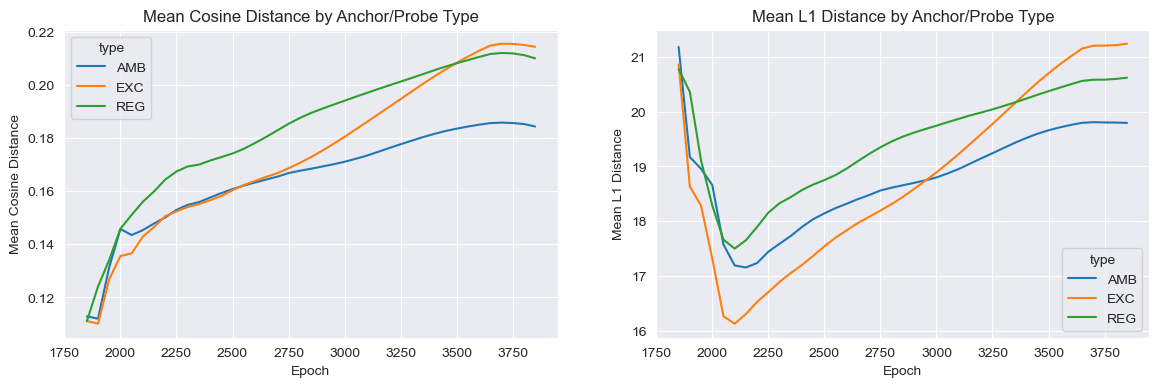

In [8]:
results_grp = results_df.groupby(by=['epoch', 'type']).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_grp, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title('Mean Cosine Distance by Anchor/Probe Type')

sns.lineplot(data=results_grp, x='epoch', y='mean_l1_distance', hue='type', ax=ax2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title('Mean L1 Distance by Anchor/Probe Type')

plt.show()

**Notes**
* For dilution = 3, we don't get the expected results for both distance metrics. Although the greatest distance between anchors and probes are still in the exceptions, the smallest distance occurs for the ambiguous anchors instead.

## Anchor-Probe Distance by Anchor
* We refer to each anchor/probe set by the first anchor.

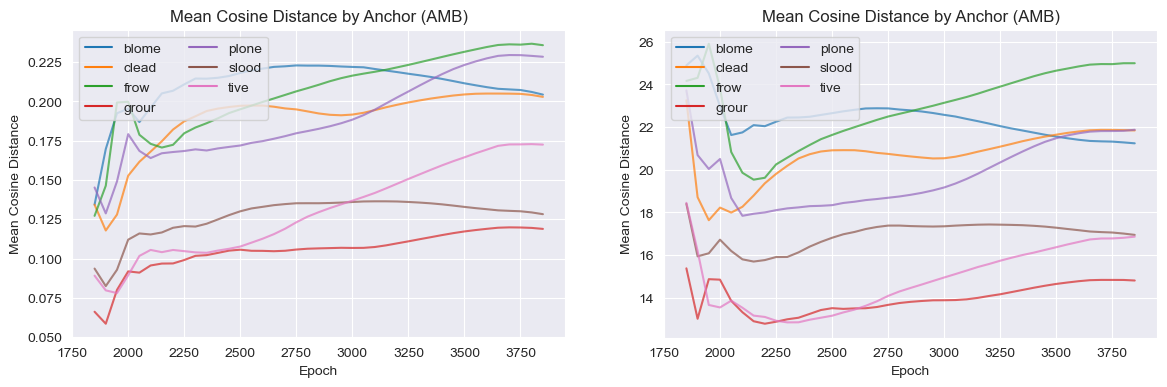

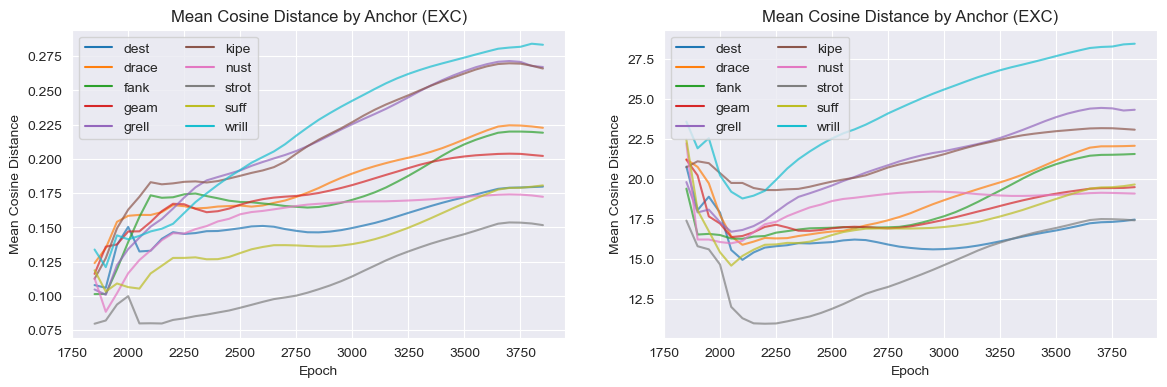

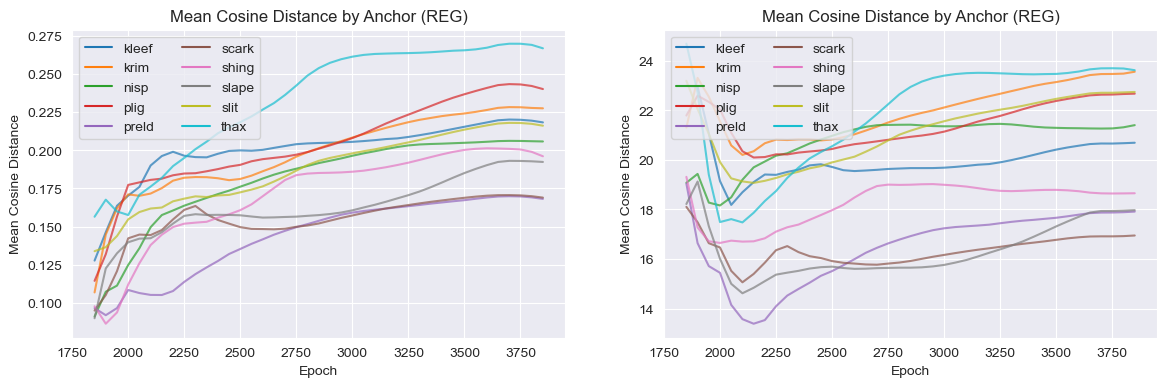

In [9]:
for word_type in results_df['type'].unique():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor', alpha=0.7, ax=ax1)
    ax1.legend(ncol=2, loc='upper left')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Cosine Distance')
    ax1.set_title(f'Mean Cosine Distance by Anchor ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor', alpha=0.7, ax=ax2)
    ax2.legend(ncol=2, loc='upper left')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Cosine Distance')
    ax2.set_title(f'Mean Cosine Distance by Anchor ({word_type})')

    plt.show()

**Notes**:
* The 'thax' anchor set is not a significant outlier anymore. Even after removing it, we still do not get the results that we expect.

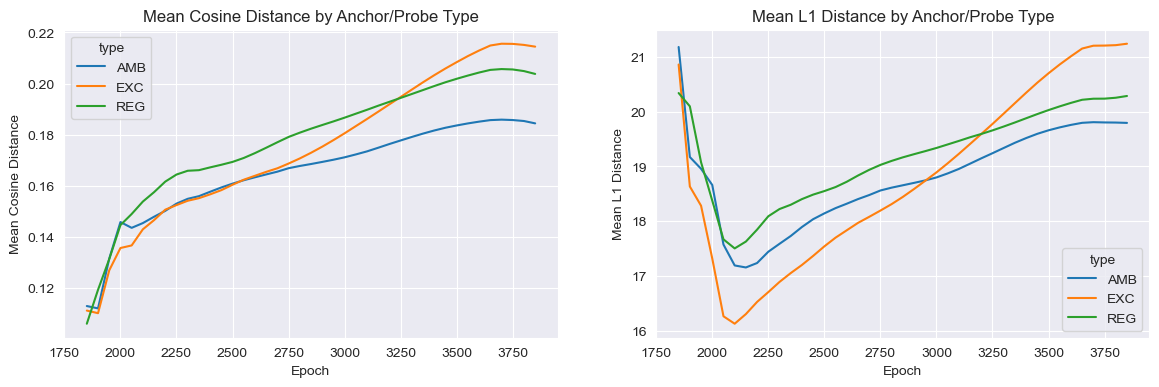

In [10]:
results_grp = results_df[results_df['first_anchor'] != 'thax'].groupby(by=['epoch', 'type']).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_grp, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title('Mean Cosine Distance by Anchor/Probe Type')

sns.lineplot(data=results_grp, x='epoch', y='mean_l1_distance', hue='type', ax=ax2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title('Mean L1 Distance by Anchor/Probe Type')

plt.show()